# Visualization of the AirBNB Dataset and Early Impressions

## Let's take care of some bookkeepping first.

Do our imports and read in the training sets with pandas.

In [1]:
# Imports 
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
import csv
import numpy as np
import seaborn as sns
from datetime import datetime
import math

# Machine Learning Packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

# Enable in-line plots and set the style for the plots
%matplotlib inline
sns.set_style("whitegrid")

In [2]:
# Read some of the data

session = pd.read_csv("data/sessions.csv")
train = pd.read_csv("data/train_users_2.csv")

#### Session has mostly details about the sessions about the various sessions.  For now, I'm not going to look at that and focus on the users.  The sessions, however, could easily have some important information.  That's for a later session.

In [3]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


Some interesting parameters that could easily have some **obvious** impact:
* gender (C)
* age (N)
* signup_method (C)
* singup_flow (?)
* language (C)
* affiliate_channel (C)
* affiliate_provider (C)
* signup_app
* first_device_type
* first_browser
* time since account was created that first booking was done

**Country_destination** is where they go.


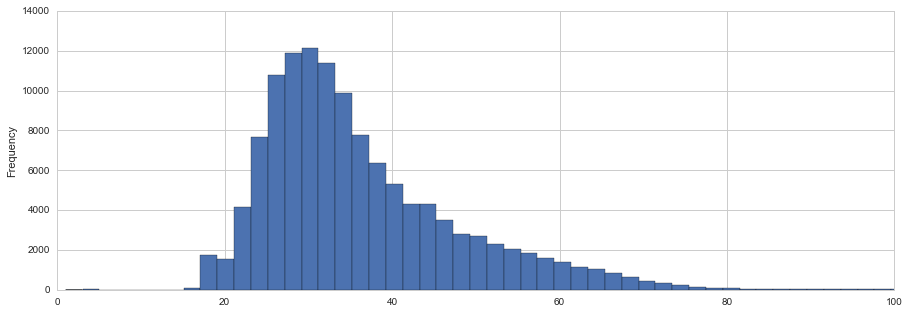

In [4]:
# Let's look at the distribution of ages to see how we want to repair that data.

# Plot the original Age Values
train["age"].plot(kind="hist", figsize=(15, 5), bins=1000, xlim=(0, 100))

The age distribution is well-peaked. There are entries at very large ages (2014 for example) and there are NaNs.  Let's treat both of those like bad data and clean them up. For now, I'm going to set these high values to NaN. Since some of them are so high 2014, I doubt all are birth years.

/Users/rcool/soft/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/rcool/soft/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


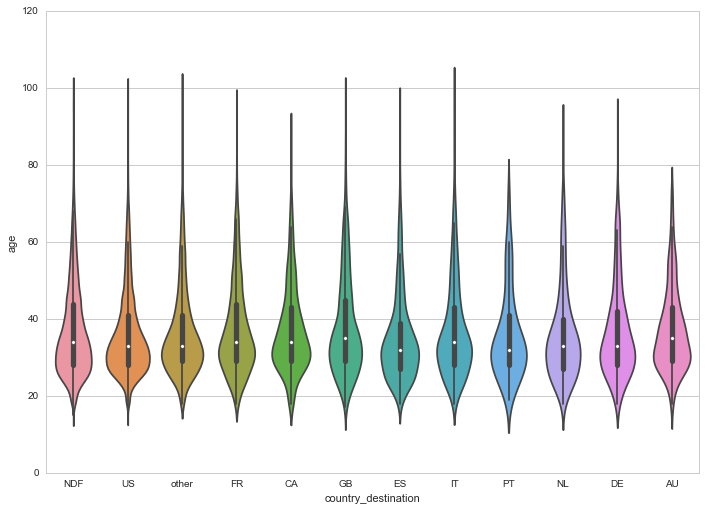

In [5]:
# Ages beyond 100 years are likely not real.
train["age"][train["age"]>100] = float("NaN")
# So are ages under 15 (hopefully they aren't booking things online).
train["age"][train["age"]<15] = float("NaN")

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.violinplot(x="country_destination", y="age", data=train, ax=ax, ylim=(15, 50), aspect=5)

(15, 60)

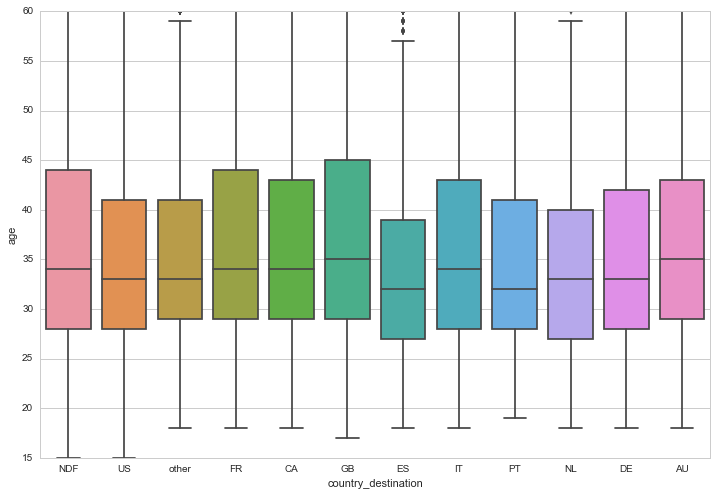

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
sns.boxplot(x='country_destination', y='age', data=train,  ax =ax)
ax.set_ylim([15, 60])

## Does the presence of an age mean anything?

In [7]:
hasAge = train[train["age"].isnull()==0]
noAge = train[train["age"].isnull()]

fracBookedwithAge = len(hasAge[hasAge["country_destination"]!="NDF"]) / len(hasAge)
fracBookedWOAge = len(noAge[noAge["country_destination"] != "NDF"]) / len(noAge)

print("Fraction who provided Age that Booked : %5.3f" % fracBookedwithAge)
print("Fraction who didn't provide Age that Booked : %5.3f" % fracBookedWOAge)

Fraction who provided Age that Booked : 0.546
Fraction who didn't provide Age that Booked : 0.240


Well, that's quite interesting.  It seems that people that provide an age are very very much more likely to book (how this affects where they book is another question, but we probably don't want to ignore this fact).

Let's create a new entry in the data that includes a flag (0/1) if the user provided their age.  This may be an interesting fact.

In [8]:
# Add a feature that tracks if they provided an age
train["gaveAge"] = (train["age"].isnull() == 0)

## Let's look at the difference between initial viewing and booking

In [9]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return (d2-d1).days

In [10]:
nullBooking = train["date_first_booking"][train["date_first_booking"].isnull()].index


In [11]:
# Find the difference between account creation and first booking
d1_vector = train["date_account_created"].values
d2_vector = train["date_first_booking"].values

elapsed = []
for ii in range(0, len(train)):
    if ii in nullBooking:
        elapsed.append(float("NaN"))
    else:
        elapsed.append(days_between(d1_vector[ii], d2_vector[ii]))

# Add this to the DataFrame
extracol = pd.DataFrame({"elapsed_booking_time":0}, index=list(train.index))
train = pd.concat([train, extracol], axis=1)
train["elapsed_booking_time"] = elapsed

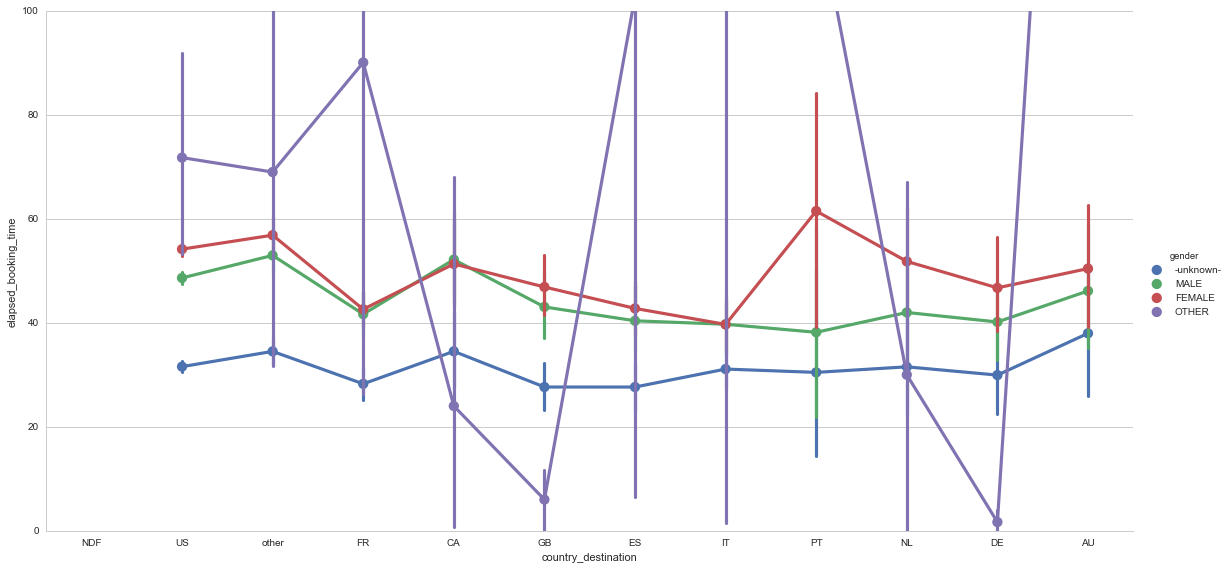

In [12]:
g = sns.factorplot(x="country_destination", y="elapsed_booking_time", 
              data=train, size=8, aspect=2, hue="gender")
g.set(ylim=(0, 100))

It's not clear that was a useful exercise. The averages are much lower than the standard deviation.  The range may be interesting -- the standard deviations are interesting ranges, but I'm not sure what they say. The "others" are very small number statistics, so I'm not sure how much to read into that line so far.  It's inderesting that unknown group does tend to book more quickly than men who tend to book more quickly than women.

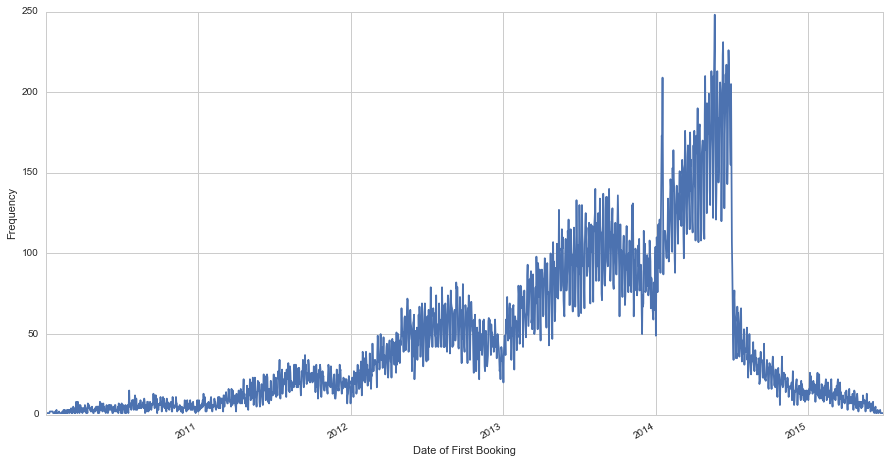

In [13]:
fig, axes = plt.subplots(figsize=(15,8))
train['date_first_booking'] = pd.to_datetime(train['date_first_booking'])
train['date_first_booking'].value_counts().plot(kind='line', ax=axes)
fig.autofmt_xdate()
plt.xlabel("Date of First Booking")
plt.ylabel("Frequency")

# Some sort of fitting 
Now, I need to decide what parameters to use in a model (at least a first pass).

Let's get rid of some useless info - id, timestamp_first_active

In [14]:
train = train.drop(["id", "timestamp_first_active"], axis=1)

In [20]:
from airbnb_tools import * 

In [ ]:
cat_var = categorical_variables(train)
splitTrain = split_categorical_variables(train, cat_var)

In [ ]:
splitTrain.head()